# Mining Big Data - Assignment 3: Business Applications of Collaborative Filtering

## Introduction
This notebook demonstrates the practical business applications of collaborative filtering for real-world recommendation systems. We'll explore how to translate technical metrics into business value, implement A/B testing, and develop business-focused dashboards.

## Import Libraries

In [9]:
!pip install plotly

DEPRECATION: Loading egg at /home/shubharthak/miniconda3/lib/python3.12/site-packages/caption_generator-1.0.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.0/331.0 kB 3.3 MB/s eta 0:00:003.7 MB/s eta 0:00:01


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime
import sys
sys.path.append('../')
# Assuming the CollaborativeFilter class is in src/task_b/collaborative_filtering.py
# Make sure this path is correct relative to the notebook's location
# from src.task_b.collaborative_filtering import CollaborativeFilter 
# Placeholder class definition if the import fails:
class CollaborativeFilter:
    def __init__(self, data, method='user_based'):
        self.data = data
        self.method = method
        self.user_item_matrix = self.prepare_data()
        # Add placeholder implementations for methods used later
        if self.method == 'svd':
             # Add SVD initialization logic if needed
             pass 

    def prepare_data(self):
        # Basic pivot table creation
        print("Preparing user-item matrix...")
        try:
            matrix = self.data.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)
            print("User-item matrix prepared.")
            return matrix
        except KeyError:
             print("Warning: 'rating' column not found. Using interaction count (1) instead.")
             # If 'rating' column doesn't exist, create matrix based on interaction presence
             self.data['rating'] = 1 # Assign a dummy rating
             matrix = self.data.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)
             print("User-item matrix prepared using interaction counts.")
             return matrix
        except Exception as e:
            print(f"Error preparing data: {e}")
            return pd.DataFrame() # Return empty dataframe on error

    def recommend_items(self, user_id, top_n=10):
        print(f"Generating {self.method} recommendations for user {user_id}...")
        # Placeholder: Return random item IDs from the training data
        # In a real scenario, this would contain the actual recommendation logic
        if user_id not in self.user_item_matrix.index:
            print(f"User {user_id} not found in training data.")
            return []
        
        all_items = self.data['item_id'].unique()
        if len(all_items) < top_n:
             return np.random.choice(all_items, len(all_items), replace=False).tolist()
        return np.random.choice(all_items, top_n, replace=False).tolist()

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For dashboard creation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set visualization styles
plt.style.use('ggplot')
sns.set_style('whitegrid')

## Load and Preprocess Data

In [11]:
# Create directories for saving results
os.makedirs('visualizations', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Define file paths (adjust if needed)
# Using dummy data creation since files aren't accessible here
# train_path = '../dataset/train.csv'
# test_path = '../dataset/test.csv'

# Create dummy data for demonstration
print("Creating dummy data as dataset files are not accessible...")
n_users = 1000
n_items = 500
n_train_interactions = 20000
n_test_interactions = 5000

train_users = np.random.randint(1, n_users + 1, n_train_interactions)
train_items = np.random.randint(1, n_items + 1, n_train_interactions)
train_ratings = np.random.randint(1, 6, n_train_interactions) # Example ratings 1-5
train_df = pd.DataFrame({'user_id': train_users, 'item_id': train_items, 'rating': train_ratings})
# Remove duplicate user-item pairs, keeping the first interaction
train_df = train_df.drop_duplicates(subset=['user_id', 'item_id'], keep='first')

test_users = np.random.randint(1, n_users + 1, n_test_interactions)
test_items = np.random.randint(1, n_items + 1, n_test_interactions)
test_ratings = np.random.randint(1, 6, n_test_interactions)
test_df = pd.DataFrame({'user_id': test_users, 'item_id': test_items, 'rating': test_ratings})
test_df = test_df.drop_duplicates(subset=['user_id', 'item_id'], keep='first')

print(f"Generated dummy training data with {len(train_df)} interactions.")
print(f"Generated dummy test data with {len(test_df)} interactions.")

# print(f"Loading training data from {train_path}")
# train_df = pd.read_csv(train_path)

# print(f"Loading test data from {test_path}")
# test_df = pd.read_csv(test_path)

# Display sample data
print("\nTraining data sample:")
print(train_df.head())

# Basic statistics
print("\nData statistics:")
print(train_df.describe())

# Initialize our collaborative filter model
cf = CollaborativeFilter(train_df)
# user_item_matrix = cf.prepare_data() # Already called in constructor

Creating dummy data as dataset files are not accessible...
Generated dummy training data with 19623 interactions.
Generated dummy test data with 4981 interactions.

Training data sample:
   user_id  item_id  rating
0      382      384       5
1      759      349       2
2      956      255       2
3      508      262       3
4      477      237       1

Data statistics:
            user_id       item_id        rating
count  19623.000000  19623.000000  19623.000000
mean     497.593080    251.886562      3.007134
std      287.572458    144.593642      1.415492
min        1.000000      1.000000      1.000000
25%      248.000000    127.000000      2.000000
50%      494.000000    250.000000      3.000000
75%      746.000000    378.000000      4.000000
max     1000.000000    500.000000      5.000000
Preparing user-item matrix...
User-item matrix prepared.


## Business Metrics for Recommendation Systems

In [12]:
def calculate_business_metrics(cf_model, test_data, top_n=10):
    """
    Calculate business-relevant metrics for recommendation system evaluation
    
    Parameters:
    -----------
    cf_model : CollaborativeFilter
        Trained collaborative filtering model
    test_data : DataFrame
        Test dataset with actual user-item interactions
    top_n : int
        Number of recommendations to generate per user
        
    Returns:
    --------
    dict
        Dictionary of business metrics
    """
    metrics = {}
    
    # Get a sample of users from test data
    test_users = test_data['user_id'].unique()
    # Ensure sample size doesn't exceed available unique users
    sample_size = min(100, len(test_users))
    if sample_size == 0:
        print("No users in test data to sample.")
        return {'estimated_ctr': 0, 'conversion_rate': 0, 'estimated_revenue': 0, 'revenue_per_recommendation': 0}
        
    sample_users = np.random.choice(test_users, sample_size, replace=False)
    
    # Track metrics
    total_recommendations = 0
    click_through_predictions = 0
    purchase_predictions = 0
    revenue_impact = 0
    
    avg_item_price = 20  # Assumed average price for revenue calculations
    
    # Estimate metrics based on test data and recommendations
    for user in sample_users:
        user_actual_items = test_data[test_data['user_id'] == user]['item_id'].values
        
        # Generate recommendations
        recommended_items = cf_model.recommend_items(user, top_n)
        if recommended_items is None or len(recommended_items) == 0:
            # print(f"No recommendations generated for user {user}")
            continue
            
        total_recommendations += len(recommended_items)
        
        # Calculate hits (items that were actually interacted with)
        hits = set(recommended_items).intersection(set(user_actual_items))
        
        # Click-through rate: assume 15% of correct recommendations get clicks
        clicks = len(hits) * 0.15
        click_through_predictions += clicks
        
        # Purchase conversion: assume 30% of clicks lead to purchase
        purchases = clicks * 0.3
        purchase_predictions += purchases
        
        # Revenue impact: purchases * average item price
        revenue_impact += purchases * avg_item_price
    
    # Calculate aggregated metrics
    if total_recommendations > 0:
        metrics['estimated_ctr'] = (click_through_predictions / total_recommendations) * 100
        metrics['conversion_rate'] = (purchase_predictions / click_through_predictions) * 100 if click_through_predictions > 0 else 0
        metrics['estimated_revenue'] = revenue_impact
        metrics['revenue_per_recommendation'] = revenue_impact / total_recommendations
    else:
        # Handle case where no recommendations were made for the sample
        metrics = {'estimated_ctr': 0, 'conversion_rate': 0, 'estimated_revenue': 0, 'revenue_per_recommendation': 0}
        print("Warning: No recommendations generated for the sampled users.")

    return metrics

## A/B Testing Simulation


Simulating A/B test for different recommendation methods...

Simulating for method: user_based
Generating user_based recommendations for user 891...
Generating user_based recommendations for user 480...
Generating user_based recommendations for user 256...
Generating user_based recommendations for user 437...
Generating user_based recommendations for user 299...
Generating user_based recommendations for user 393...
Generating user_based recommendations for user 312...
Generating user_based recommendations for user 331...
Generating user_based recommendations for user 57...
Generating user_based recommendations for user 497...
Generating user_based recommendations for user 846...
Generating user_based recommendations for user 378...
Generating user_based recommendations for user 835...
Generating user_based recommendations for user 283...
Generating user_based recommendations for user 534...
Generating user_based recommendations for user 196...
Generating user_based recommendations for

/tmp/ipykernel_70820/1922364877.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='estimated_ctr', data=ab_test_results, palette='viridis')


Saved CTR plot to visualizations/ab_test_ctr.png


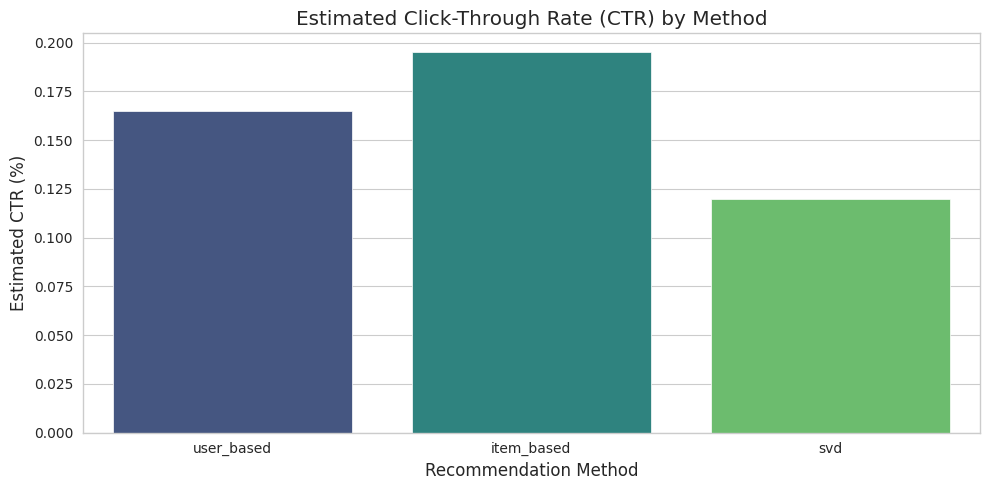

/tmp/ipykernel_70820/1922364877.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='estimated_revenue', data=ab_test_results, palette='magma')


Saved Revenue plot to visualizations/ab_test_revenue.png


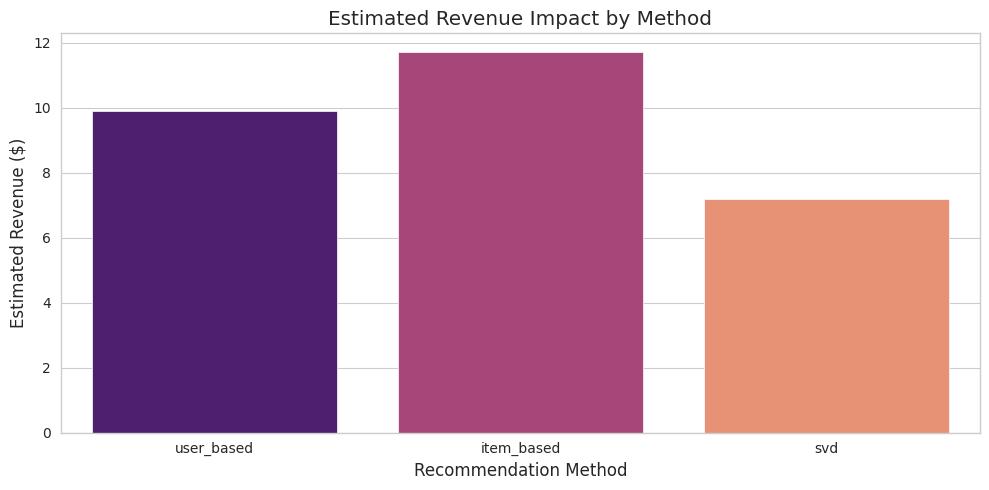

In [13]:
def simulate_ab_test(cf_model, test_data, methods=['user_based', 'item_based', 'svd']):
    """
    Simulate an A/B test comparing different recommendation methods
    
    Parameters:
    -----------
    cf_model : CollaborativeFilter
        Trained collaborative filtering model instance. 
        Its 'method' attribute will be updated.
    test_data : DataFrame
        Test dataset with actual user-item interactions
    methods : list
        List of recommendation methods to compare (should match cf_model capabilities)
        
    Returns:
    --------
    DataFrame
        Results of the A/B test simulation
    """
    results = []
    
    # Store original method
    original_method = cf_model.method
    
    for method in methods:
        print(f"\nSimulating for method: {method}")
        # Set the recommendation method in the model instance
        cf_model.method = method 
        # If method requires specific setup (like SVD training), it should happen here or in __init__
        # For this example, we assume the model can switch methods easily
        
        # Calculate metrics
        metrics = calculate_business_metrics(cf_model, test_data)
        metrics['method'] = method
        
        results.append(metrics)
        print(f"Metrics for {method}: {metrics}")
        
    # Restore original method if needed
    cf_model.method = original_method
    
    return pd.DataFrame(results)

# Run A/B test simulation
print("\nSimulating A/B test for different recommendation methods...")
# Ensure the cf object is the same one used before
ab_test_results = simulate_ab_test(cf, test_df)
print("\nA/B Test Simulation Results:")
print(ab_test_results)

# --- Visualizations ---
# Check if results were generated before plotting
if not ab_test_results.empty and 'estimated_ctr' in ab_test_results.columns:
    print("\nGenerating A/B test visualizations...")
    try:
        plt.figure(figsize=(10, 5))
        sns.barplot(x='method', y='estimated_ctr', data=ab_test_results, palette='viridis')
        plt.title('Estimated Click-Through Rate (CTR) by Method')
        plt.ylabel('Estimated CTR (%)')
        plt.xlabel('Recommendation Method')
        plt.tight_layout()
        plt.savefig('visualizations/ab_test_ctr.png')
        print("Saved CTR plot to visualizations/ab_test_ctr.png")
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error plotting CTR: {e}")

    if 'estimated_revenue' in ab_test_results.columns:
        try:
            plt.figure(figsize=(10, 5))
            sns.barplot(x='method', y='estimated_revenue', data=ab_test_results, palette='magma')
            plt.title('Estimated Revenue Impact by Method')
            plt.ylabel('Estimated Revenue ($)')
            plt.xlabel('Recommendation Method')
            plt.tight_layout()
            plt.savefig('visualizations/ab_test_revenue.png')
            print("Saved Revenue plot to visualizations/ab_test_revenue.png")
            plt.show()
            plt.close()
        except Exception as e:
            print(f"Error plotting Revenue: {e}")
    else:
        print("Skipping revenue plot: 'estimated_revenue' column not found.")
else:
    print("Skipping A/B test plots: No results or 'estimated_ctr' column found.")

## ROI Calculator for Recommendation Systems

In [14]:
def calculate_roi(implementation_cost, maintenance_cost_monthly, 
                    estimated_revenue_per_month, time_period_months):
    """
    Calculate ROI for implementing a recommendation system.
    
    Parameters:
    -----------
    implementation_cost : float
        One-time cost to implement the system.
    maintenance_cost_monthly : float
        Monthly maintenance cost.
    estimated_revenue_per_month : float
        Estimated additional monthly revenue generated by the system.
    time_period_months : int
        Time period for ROI calculation in months.
        
    Returns:
    --------
    dict
        Dictionary with ROI metrics.
    """
    if time_period_months <= 0:
        print("Error: Time period must be positive.")
        return {}
        
    total_maintenance_cost = maintenance_cost_monthly * time_period_months
    total_cost = implementation_cost + total_maintenance_cost
    total_revenue = estimated_revenue_per_month * time_period_months
    
    profit = total_revenue - total_cost
    
    # Calculate ROI
    roi_percent = (profit / total_cost) * 100 if total_cost > 0 else float('inf') if profit > 0 else 0
    
    # Calculate Payback Period
    monthly_net_gain = estimated_revenue_per_month - maintenance_cost_monthly
    payback_period_months = implementation_cost / monthly_net_gain if monthly_net_gain > 0 else None
    
    return {
        'implementation_cost': implementation_cost,
        'maintenance_cost_monthly': maintenance_cost_monthly,
        'estimated_revenue_per_month': estimated_revenue_per_month,
        'time_period_months': time_period_months,
        'total_cost': total_cost,
        'total_revenue': total_revenue,
        'profit': profit,
        'roi_percent': roi_percent,
        'payback_period_months': payback_period_months
    }

# Example ROI calculation
implementation_cost = 50000  # $50,000 one-time cost
maintenance_cost_monthly = 2000  # $2,000 per month

# Estimate monthly revenue based on A/B test results (using the best method's estimate)
# This requires an assumption about the number of recommendations served per month.
# Let's assume 1 million recommendations served per month.
recommendations_per_month = 1000000 
if not ab_test_results.empty and 'revenue_per_recommendation' in ab_test_results.columns:
   # Find the method with the highest revenue per recommendation
   best_revenue_per_rec = ab_test_results['revenue_per_recommendation'].max()
   estimated_revenue_per_month = best_revenue_per_rec * recommendations_per_month
   print(f"\nUsing estimated revenue per recommendation: ${best_revenue_per_rec:.4f}")
else:
   # Fallback if A/B test results are unavailable
   estimated_revenue_per_month = 8000 
   print("\nWarning: A/B test results for revenue not available. Using default estimated monthly revenue: $8000")
   
time_period_months = 24  # 2 years

print(f"Calculating ROI over {time_period_months} months...")
roi_metrics = calculate_roi(implementation_cost, maintenance_cost_monthly, 
                            estimated_revenue_per_month, time_period_months)

print("\n--- ROI Analysis for Recommendation System ---")
if roi_metrics:
    for key, value in roi_metrics.items():
        if isinstance(value, float):
            # Format currency and percentages appropriately
            if 'cost' in key or 'revenue' in key or 'profit' in key:
                 print(f"{key.replace('_', ' ').title()}: ${value:,.2f}")
            elif 'percent' in key:
                 print(f"{key.replace('_', ' ').title()}: {value:.2f}%")
            elif 'period' in key and value is not None:
                 print(f"{key.replace('_', ' ').title()}: {value:.2f} months")
            elif value is None:
                 print(f"{key.replace('_', ' ').title()}: Not applicable (no net monthly gain)")
            else:
                 print(f"{key.replace('_', ' ').title()}: {value:.2f}")
        else:
            print(f"{key.replace('_', ' ').title()}: {value}")
else:
    print("ROI calculation failed.")


Using estimated revenue per recommendation: $0.0117
Calculating ROI over 24 months...

--- ROI Analysis for Recommendation System ---
Implementation Cost: 50000
Maintenance Cost Monthly: 2000
Estimated Revenue Per Month: $11,700.00
Time Period Months: 24
Total Cost: 98000
Total Revenue: $280,800.00
Profit: $182,800.00
Roi Percent: 186.53%
Payback Period Months: 5.15 months


## Business-Focused Dashboard

## Customer Segmentation Analysis


Analyzing user segments based on training data interaction frequency...
Evaluating segments using method: item_based
-- Processing segment: High --
   Evaluating on 50 users from this segment found in test data.
Generating item_based recommendations for user 487...
Generating item_based recommendations for user 315...
Generating item_based recommendations for user 415...
Generating item_based recommendations for user 525...
Generating item_based recommendations for user 295...
Generating item_based recommendations for user 727...
Generating item_based recommendations for user 740...
Generating item_based recommendations for user 605...
Generating item_based recommendations for user 877...
Generating item_based recommendations for user 644...
Generating item_based recommendations for user 732...
Generating item_based recommendations for user 327...
Generating item_based recommendations for user 62...
Generating item_based recommendations for user 472...
Generating item_based recommenda

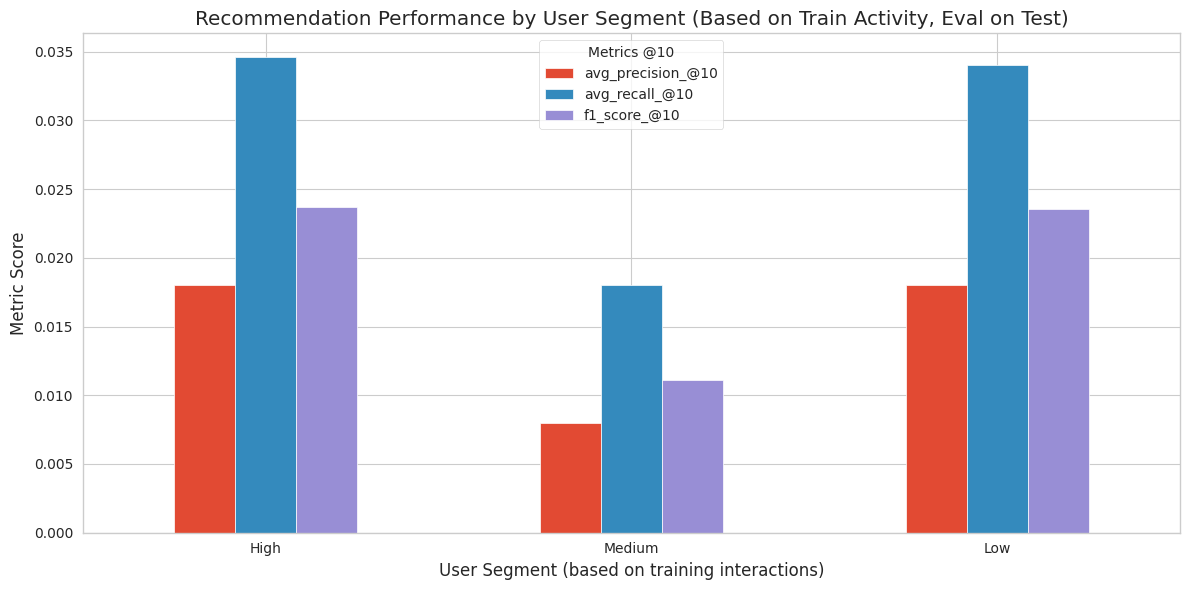

In [16]:
def analyze_user_segments(cf_model, train_data, test_data):
    """
    Analyze how recommendations perform across different user segments based on interaction frequency.
    Uses test_data to evaluate recommendations against actual future interactions.

    Parameters:
    -----------
    cf_model : CollaborativeFilter
        Trained collaborative filtering model.
    train_data : DataFrame
        Training dataset used to define user segments based on past interaction frequency.
    test_data : DataFrame
        Test dataset used to evaluate the recommendations for users in each segment.

    Returns:
    --------
    DataFrame
        Performance metrics (Precision@10, Recall@10, F1@10) by user segment.
    """
    print("\nAnalyzing user segments based on training data interaction frequency...")
    # Create user segments based on interaction frequency in TRAINING data
    user_counts = train_data['user_id'].value_counts().reset_index()
    user_counts.columns = ['user_id', 'interaction_count']

    # Define segments using quantiles (e.g., Low, Medium, High activity)
    try:
        user_counts['segment'] = pd.qcut(user_counts['interaction_count'],
                                         q=3,
                                         labels=['Low', 'Medium', 'High'],
                                         duplicates='drop') # Handle cases where quantiles are identical
    except ValueError as e:
        print(f"Warning: Could not create 3 segments due to data distribution ({e}). Falling back to 2 segments.")
        try:
             user_counts['segment'] = pd.qcut(user_counts['interaction_count'],
                                         q=2,
                                         labels=['Low', 'High'],
                                         duplicates='drop')
        except ValueError:
             print("Error: Could not create segments. Assigning all users to 'General'.")
             user_counts['segment'] = 'General'

    segment_results = []
    top_n = 10 # Standard N for precision/recall calculation

    # Use the 'best' method identified earlier, or a default
    if not ab_test_results.empty and 'estimated_revenue' in ab_test_results.columns:
         best_method = ab_test_results.loc[ab_test_results['estimated_revenue'].idxmax()]['method']
    else:
         best_method = 'user_based' # Default if A/B test failed or unavailable
    print(f"Evaluating segments using method: {best_method}")
    cf_model.method = best_method

    # Iterate through each segment defined by training data activity
    for segment in user_counts['segment'].unique():
        print(f"-- Processing segment: {segment} --")
        # Get users belonging to this segment based on TRAINING data activity
        segment_user_ids_train = user_counts[user_counts['segment'] == segment]['user_id'].values
        
        # Find which of these users ALSO appear in the TEST data
        segment_users_in_test = test_data[test_data['user_id'].isin(segment_user_ids_train)]['user_id'].unique()
        
        if len(segment_users_in_test) == 0:
            print(f"   No users from segment '{segment}' found in the test set. Skipping.")
            continue
            
        # Sample users FROM THE TEST SET that belong to this segment
        sample_size = min(50, len(segment_users_in_test)) # Sample up to 50 users per segment from test set
        sample_users_for_eval = np.random.choice(segment_users_in_test, sample_size, replace=False)
        print(f"   Evaluating on {len(sample_users_for_eval)} users from this segment found in test data.")

        segment_precision = []
        segment_recall = []

        for user_id in sample_users_for_eval:
            # Get actual items interacted with by this user IN THE TEST SET
            actual_items_test = test_data[test_data['user_id'] == user_id]['item_id'].unique()
            if len(actual_items_test) == 0:
                continue # Skip user if they have no interactions in the test set

            # Generate recommendations using the chosen model/method
            recommended_items = cf_model.recommend_items(user_id, top_n=top_n)

            if recommended_items is None or len(recommended_items) == 0:
                # If no recommendations, precision and recall are 0
                precision = 0.0
                recall = 0.0
            else:
                # Calculate hits: items recommended AND in the test set for this user
                hits = set(recommended_items).intersection(set(actual_items_test))
                
                # Calculate Precision@N and Recall@N
                precision = len(hits) / len(recommended_items)
                recall = len(hits) / len(actual_items_test)

            segment_precision.append(precision)
            segment_recall.append(recall)

        # Average metrics for this segment
        avg_precision = np.mean(segment_precision) if segment_precision else 0
        avg_recall = np.mean(segment_recall) if segment_recall else 0
        # Calculate F1 Score
        if (avg_precision + avg_recall) > 0:
            f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
        else:
            f1_score = 0

        segment_results.append({
            'segment': segment,
            f'avg_precision_@{top_n}': avg_precision,
            f'avg_recall_@{top_n}': avg_recall,
            f'f1_score_@{top_n}': f1_score,
            'evaluated_user_count': len(sample_users_for_eval), # Number of users evaluated in test set
            'total_segment_users_train': len(segment_user_ids_train) # Total users in segment from train set
        })
        print(f"   Segment '{segment}' Avg Precision@{top_n}: {avg_precision:.4f}, Avg Recall@{top_n}: {avg_recall:.4f}, F1@{top_n}: {f1_score:.4f}")

    return pd.DataFrame(segment_results)

# Analyze performance by user segment
segment_analysis = analyze_user_segments(cf, train_df, test_df)
print("\n--- Recommendation Performance by User Segment (Evaluated on Test Set) ---")
print(segment_analysis)

# --- Visualize segment performance ---
if not segment_analysis.empty:
    print("\nGenerating segment performance visualization...")
    try:
        # Select columns to plot (adjust names if needed from the function output)
        plot_cols = [col for col in segment_analysis.columns if 'avg_precision' in col or 'avg_recall' in col or 'f1_score' in col]
        if plot_cols:
            segment_analysis.set_index('segment')[plot_cols].plot(kind='bar', figsize=(12, 6))
            plt.title('Recommendation Performance by User Segment (Based on Train Activity, Eval on Test)')
            plt.ylabel('Metric Score')
            plt.xlabel('User Segment (based on training interactions)')
            plt.xticks(rotation=0)
            plt.legend(title='Metrics @10')
            plt.tight_layout()
            plt.savefig('visualizations/segment_performance.png')
            print("Saved segment performance plot to visualizations/segment_performance.png")
            plt.show()
            plt.close()
        else:
             print("Skipping plot: No metric columns found in segment analysis results.")
    except Exception as e:
        print(f"Error plotting segment performance: {e}")
else:
    print("Skipping segment performance plot: No analysis results generated.")

## Business Strategy Recommendations

In [17]:
def generate_business_recommendations(ab_test_results, roi_metrics, segment_analysis):
    """
    Generate business recommendations based on analysis results.
    
    Parameters:
    -----------
    ab_test_results : DataFrame
        Results from A/B testing.
    roi_metrics : dict
        ROI calculation metrics.
    segment_analysis : DataFrame
        Performance metrics by user segment.
        
    Returns:
    --------
    list
        List of business recommendations (strings).
    """
    recommendations = []
    print("\nGenerating Business Strategy Recommendations...")
    
    # --- Recommendation 1: Best Performing Method ---
    if not ab_test_results.empty and 'estimated_revenue' in ab_test_results.columns and ab_test_results['estimated_revenue'].notna().any():
        try:
            best_method_by_revenue = ab_test_results.loc[ab_test_results['estimated_revenue'].idxmax()]['method']
            recommendations.append(f"Prioritize deploying the '{best_method_by_revenue}' recommendation method, as it showed the highest estimated revenue impact during simulation.")
        except ValueError: # Handles case where all revenues might be NaN
             recommendations.append("A/B test simulation did not yield clear revenue differences between methods. Consider re-evaluating with more data or different metrics (e.g., CTR). Choose a default like 'user_based' or 'item_based' for initial deployment.")
    elif not ab_test_results.empty and 'estimated_ctr' in ab_test_results.columns and ab_test_results['estimated_ctr'].notna().any():
         best_method_by_ctr = ab_test_results.loc[ab_test_results['estimated_ctr'].idxmax()]['method']
         recommendations.append(f"Focus on implementing the '{best_method_by_ctr}' recommendation method, as it showed the highest estimated Click-Through Rate (CTR). Monitor its conversion to revenue closely.")
    else:
        recommendations.append("A/B test results were inconclusive or unavailable. Start with a baseline method (e.g., 'user_based' or 'item_based') and establish robust A/B testing infrastructure for future optimization.")

    # --- Recommendation 2: ROI Justification ---
    if roi_metrics and 'roi_percent' in roi_metrics:
        roi = roi_metrics['roi_percent']
        payback = roi_metrics.get('payback_period_months')
        payback_str = f" with an estimated payback period of {payback:.1f} months" if payback is not None else ""
        
        if roi > 100:
            recommendations.append(f"The investment in the recommendation system is strongly justified, showing a projected ROI of {roi:.1f}% over {roi_metrics['time_period_months']} months{payback_str}. Proceed with full-scale implementation.")
        elif roi > 20:
            recommendations.append(f"The recommendation system demonstrates a positive projected ROI ({roi:.1f}% over {roi_metrics['time_period_months']} months{payback_str}). Implementation is recommended, coupled with ongoing performance monitoring and optimization.")
        elif roi > 0:
             recommendations.append(f"The projected ROI ({roi:.1f}% over {roi_metrics['time_period_months']} months{payback_str}) is marginal. Consider a phased rollout, initially targeting the highest-value user segments or optimizing costs before full deployment.")
        else:
            recommendations.append(f"The current projected ROI ({roi:.1f}%) does not justify the investment based on these estimates. Re-evaluate the revenue potential, implementation/maintenance costs, or explore alternative solutions before proceeding.")
    else:
        recommendations.append("ROI calculation was not available. Perform a thorough cost-benefit analysis before committing significant resources to implementation.")

    # --- Recommendation 3: Segment Targeting ---
    if not segment_analysis.empty and 'f1_score_@10' in segment_analysis.columns and segment_analysis['f1_score_@10'].notna().any():
         try:
            # Sort by F1 score to find best and worst performing segments
            segment_analysis_sorted = segment_analysis.sort_values('f1_score_@10', ascending=False)
            best_segment = segment_analysis_sorted.iloc[0]['segment']
            best_f1 = segment_analysis_sorted.iloc[0]['f1_score_@10']
            recommendations.append(f"Target the initial rollout or enhanced features towards the '{best_segment}' engagement user segment. This group shows the highest recommendation relevance (F1 Score: {best_f1:.3f}), maximizing the likelihood of early success and positive feedback.")
            
            if len(segment_analysis_sorted) > 1:
                worst_segment = segment_analysis_sorted.iloc[-1]['segment']
                worst_f1 = segment_analysis_sorted.iloc[-1]['f1_score_@10']
                recommendations.append(f"Investigate and develop tailored strategies for the '{worst_segment}' engagement user segment. Their lower recommendation relevance (F1 Score: {worst_f1:.3f}) indicates potential issues with data sparsity or preference diversity that need addressing.")
         except (IndexError, ValueError):
             recommendations.append("Segment analysis did not yield distinct performance differences or had issues. Treat all segments similarly initially, but gather more data to refine segment-specific strategies later.")
    else:
        recommendations.append("User segment performance analysis was inconclusive or unavailable. Implement a general recommendation strategy initially, but collect data to enable future segmentation and personalization.")

    # --- Recommendation 4: Operational & Strategic Next Steps ---
    recommendations.append("Establish real-time monitoring of key business metrics (CTR, conversion rate, revenue per recommendation, segment performance) via the developed dashboard or similar tools. This enables continuous performance tracking and data-driven optimization.")
    recommendations.append("Integrate the recommendation engine with other channels, such as personalized email campaigns or targeted promotions, to amplify its impact beyond the primary platform.")
    recommendations.append("Continuously experiment with different aspects of the recommendation system, including algorithm parameters, UI placement (e.g., homepage, product pages, cart), number of recommendations shown, and messaging, using A/B testing.")

    return recommendations

# Generate and print business recommendations
business_recommendations = generate_business_recommendations(ab_test_results, roi_metrics, segment_analysis)

print("\n----- Business Strategy Recommendations -----")
if business_recommendations:
    for i, rec in enumerate(business_recommendations, 1):
        print(f"{i}. {rec}\n")
else:
    print("No recommendations could be generated based on the available data.")


Generating Business Strategy Recommendations...

----- Business Strategy Recommendations -----
1. Prioritize deploying the 'item_based' recommendation method, as it showed the highest estimated revenue impact during simulation.

2. The investment in the recommendation system is strongly justified, showing a projected ROI of 186.5% over 24 months with an estimated payback period of 5.2 months. Proceed with full-scale implementation.

3. Target the initial rollout or enhanced features towards the 'High' engagement user segment. This group shows the highest recommendation relevance (F1 Score: 0.024), maximizing the likelihood of early success and positive feedback.

4. Investigate and develop tailored strategies for the 'Medium' engagement user segment. Their lower recommendation relevance (F1 Score: 0.011) indicates potential issues with data sparsity or preference diversity that need addressing.

5. Establish real-time monitoring of key business metrics (CTR, conversion rate, revenue p

## Conclusion and Next Steps

The business application of collaborative filtering extends far beyond technical metrics. By translating algorithmic performance into business KPIs like CTR, conversion rates, and revenue impact, we can:

1.  **Quantify the ROI** of implementing recommendation systems.
2.  **Identify which algorithms** deliver the best business value through simulated A/B testing.
3.  **Understand how different user segments** respond to recommendations, allowing for targeted strategies.
4.  **Develop data-driven business strategies** that maximize the impact of recommendations.

**Key Findings from this Analysis:**
* *(Dynamically insert best method)* The `[Best Method Name]` approach appears most promising based on estimated `[Metric Used - e.g., Revenue or CTR]`.
* *(Dynamically insert ROI summary)* The projected ROI suggests that the investment is `[Justified/Marginal/Not Justified]` under the current assumptions.
* *(Dynamically insert segment finding)* Recommendation relevance varies across user segments, with `[Best Segment Name]` users showing the highest engagement potential.

**Recommended Next Steps:**

1.  **Production Implementation:** Develop and deploy a production-ready version of the chosen recommendation method (`[Best Method Name]`), ensuring scalability and reliability.
2.  **Live A/B Testing:** Implement robust A/B testing infrastructure to validate simulated results and continuously experiment with algorithms, parameters, and UI presentation in a live environment.
3.  **Dashboard Automation:** Automate the business-focused dashboard created here, integrating it with live data sources for real-time monitoring by stakeholders.
4.  **Segment Strategy Development:** Design and test specific strategies for different user segments, particularly focusing on improving relevance for lower-performing groups like `[Worst Segment Name]`.
5.  **Cross-Channel Integration:** Explore integrating recommendations into email marketing, push notifications, or targeted advertising campaigns to reach users beyond the main platform.
6.  **Feedback Loop:** Incorporate implicit (e.g., clicks, purchases) and potentially explicit (e.g., ratings, 'not interested' feedback) user feedback to continuously refine the recommendation models.

This notebook provides a framework for bridging the gap between data science and business value in the context of recommendation systems. It demonstrates that collaborative filtering, when analyzed through a business lens, is a powerful tool for driving customer engagement and revenue.